In [1]:
import sys
sys.path.append('/Users/djuna/Documents/ABCA7lof2/')
# load libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import os

import os
import urllib.request
import os
import urllib.request
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
os.sys.path.append('/Users/djuna/Documents/ABCA7lof2/')
from ABCA7lof2.lcms_funcs import return_stats, plot_volcano, plot_pca, count_unsaturations, count_carbons, plot_lfcs, plot_carbon_distributions, plot_class_counts, plot_with_blank, classify_fatty_acid_length, classify_unsaturation
# load libraries

output_dir = "../../LCMS/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

urls = ['https://storage.googleapis.com/abca7lof/LCMS/SUB14737/5041.SUB14737_LipidXData.csv']

for url in urls:
    local_filename = os.path.join(output_dir, os.path.basename(url))
    urllib.request.urlretrieve(url, local_filename)
    print("Download completed!")

Download completed!


In [2]:
# load the data

output_dir = "../../../LCMS/"

# load data
data = pd.read_csv(output_dir + '2685.SUB15127_LipidXData.csv')
data.index = data['name']

# load lipid key
key = pd.read_csv(os.path.join(output_dir, 'LipidKey.csv'))
dictionary = dict(zip(key['Key'], key['Class']))

# sample key 
sample_dictionary = {'s1':'Y+H2O',
                     's2':'E3+H2O',
                     's3':'Y+C',
                     's4':'G2+H2O',
                     'c':'blank'}

lipid_palette = {
    'Sphingolipids':'#1DC9A4',
    'Neutral lipids':'#E3120B',
    'Phospholipids':'#475ED1',
    'Fatty acyl and other lipids':'#F97A1F', 
    'Neutral glycerolipid':'#E3120B',	
    'Steroid':'#F9C31F', 
    'Glycoglycerolipids':'darkblue'
}

pufa_palette = {
    'PUFA':'#333333',
    'MUFA':'#1F2E7A',
    'SFA':'#475ED1'
}

In [3]:
# get areas
areas = data[[col for col in data.columns if col.startswith('area[')]]
names = np.array([x.split('[')[1].split('-')[0] for x in areas.columns])
areas_columns = np.array([sample_dictionary[x] for x in names])

# remove blanks
areas_no_blank = areas.iloc[:,(areas_columns=='E3+H2O') | (areas_columns=='Y+H2O')]
names_no_blank = areas_columns[(areas_columns=='E3+H2O') | (areas_columns=='Y+H2O')]

# get average extraction blank
ext_blank_h20 = areas.iloc[:, areas_columns == 'blank'].median(axis=1).squeeze() #.iloc[:,0:2]

# remove extraction blank
areas_no_blank_H20_blank_removed = areas_no_blank.subtract(3*ext_blank_h20, axis=0)

# set neg values to zero
areas_no_blank_H20_blank_removed_zeroed = areas_no_blank_H20_blank_removed.copy()
areas_no_blank_H20_blank_removed_zeroed[areas_no_blank_H20_blank_removed_zeroed < 0] = 0

# get significant compounds
stats = return_stats(areas_no_blank_H20_blank_removed_zeroed, names_no_blank, 'E3+H2O', 'Y+H2O')
stats['cat'] = 'other'
stats['name'] = stats.index
stats['grp'] = [dictionary[x.split('(')[0]] for x in stats.index]

# Drop rows where fold change is NaN
stats = stats.dropna(subset=['p_value'])

# correct pvalues
stats['fdr_corrected_p_value'] = multipletests(stats['p_value'], method='fdr_bh')[1]

# add class column
stats['class'] = [x.split('(')[0] for x in stats.index]

# add unsaturation and carbon length column 
stats['carbons'] = stats['name'].apply(count_carbons)
stats['unsaturations'] = stats['name'].apply(count_unsaturations)
stats['unsat_grp'] = [classify_unsaturation(count_unsaturations(x)) for x in stats.index]


# categorize species
stats['cat'] = 'other'
stats.loc[(stats['log2_fold_change']< -1) & (stats['fdr_corrected_p_value']<0.05), 'cat'] = 'down'
stats.loc[(stats['log2_fold_change']>1) & (stats['fdr_corrected_p_value']<0.05), 'cat'] = 'up'
stats['cat'] = stats['cat'].astype(str)

stats.head()


/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:33: RuntimeWarning: divide by zero encountered in log2
  log2_fold_change = np.log2(mean_group2 / mean_group1) if mean_group1 != 0 else np.inf


,t_stat,p_value,log2_fold_change,fdr_corrected_p_value,cat,name,grp,class,carbons,unsaturations,unsat_grp
DG(18:0_16:0)+NH4_46.33,1.077612,0.307600,0.676965,0.403740,other,DG(18:0_16:0)+NH4_46.33,Neutral lipids,DG,34,0,SFA
DG(18:0e)+Na_34.38,-1.026205,0.331585,-inf,0.403740,other,DG(18:0e)+Na_34.38,Neutral lipids,DG,18,0,SFA
DG(23:5e)+H_37.99,1.000000,0.350617,inf,0.403740,other,DG(23:5e)+H_37.99,Neutral lipids,DG,23,5,PUFA
LPC(16:0)+H_29.72,2.849317,0.015551,1.281005,0.044501,up,LPC(16:0)+H_29.72,Phospholipids,LPC,16,0,SFA
LPC(16:2e)+H_28.54,1.321485,0.213571,0.700318,0.324628,other,LPC(16:2e)+H_28.54,Phospholipids,LPC,16,2,PUFA


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na o

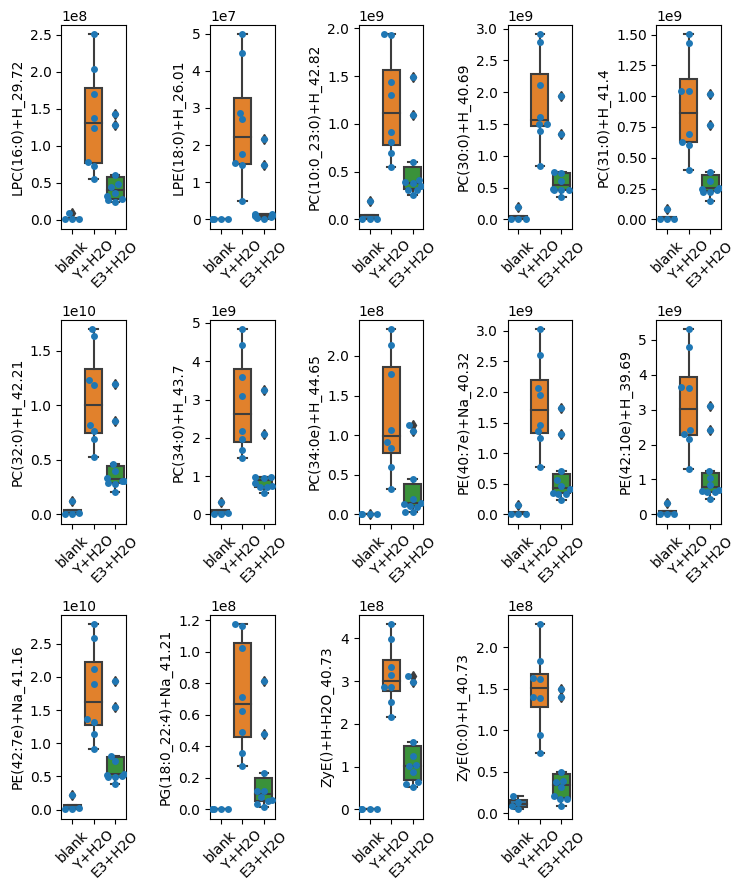

In [30]:
# show sig lipids with blanks
areas_sub = areas.loc[stats[(stats['fdr_corrected_p_value']<0.05) & (np.abs(stats['log2_fold_change'])>1)].index].iloc[:,(areas_columns=='E3+H2O') | (areas_columns=='Y+H2O') | (areas_columns=='blank')]
areas_sub.columns = areas_columns[(areas_columns=='E3+H2O') | (areas_columns=='Y+H2O') | (areas_columns=='blank')]
areas_sub = areas_sub.T
areas_sub['grp'] = areas_sub.index
plot_with_blank(areas_sub)

In [4]:
# get # of perturbed lipids per subclass

subclass_dict = dict(zip(key['Key'], key['subclass']))
grouped = stats.groupby('class')['cat'].value_counts().unstack(fill_value=0)
grouped['down'] = 0
# Compute total species per class.
grouped['Total'] = grouped.sum(axis=1)

# Compute the total perturbed (up + down) and percentage.
grouped['Perturbed'] = grouped.get('up', 0) #+ grouped.get('down', 0)
grouped['% Perturbed'] = (grouped['Perturbed'] / grouped['Total'] * 100).round(1)
grouped['total'] = grouped['up'] + grouped['down']

# Create the summary table: absolute up, absolute down, and % perturbed.
table_df = grouped[['up', 'down', 'total', '% Perturbed']].rename(
    columns={'up': 'Up', 'down': 'Down', 'total': 'Total', 'empty': ''}
)

# subset table to only include classes with more than 0 total
table_df.sort_values(by='Total', ascending=False, inplace=True)
table_df = table_df.loc[table_df['Total']>0].copy()

# add subclass
table_df['Subclass'] = [subclass_dict[x] for x in table_df.index]

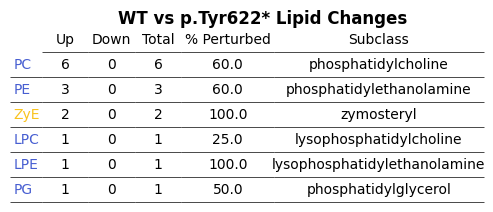

In [20]:
# plot the table 

table_palette = dict(zip(table_df.index, [lipid_palette[dictionary[x]] for x in table_df.index]))

fig, ax = plt.subplots(figsize=(3,2))
ax.axis('off')  # Hide the main axes

tbl = ax.table(cellText=table_df.values,
               rowLabels=table_df.index,
               colLabels=table_df.columns,
               cellLoc='center',
               loc='center', colWidths=[0.2, 0.2, 0.2, 0.4, 0.9])

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

# Color the row labels according to the palette.
# Matplotlib stores row labels in cells with (row, col) where col == -1.
for (row, col), cell in tbl.get_celld().items():
    if col == 0 and row > 0:  # row>0: skip header row label cell
        lipid_class = table_df.index[row-1]  # row labels start at row 1 in the table cells
        cell.set_facecolor(table_palette.get(lipid_class, 'blue'))

for key, cell in tbl.get_celld().items():
    
        cell.set_edgecolor('white')

for (row, col), cell in tbl.get_celld().items():
    if row > 0:  # for all cells in data rows
        # Show only the bottom edge:
        cell.visible_edges = 'B'
        cell.set_edgecolor('black')
        cell.set_linewidth(0.5)
    else:
        # For header row, you can keep the default (or set a full box if desired)
        cell.visible_edges = 'B'
        cell.set_edgecolor('black')
        cell.set_linewidth(0.5)

    if col == -1 and row > 0:  # skip header label cell if present
        lipid_class = table_df.index[row-1]  # adjust index for header offset
        cell.get_text().set_color(table_palette.get(lipid_class, 'black'))
plt.title('WT vs p.Tyr622* Lipid Changes', fontweight="bold", pad=10)
plt.savefig('../../../paper/main_plots/lipids_table_y622.png', dpi=300, bbox_inches='tight')


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


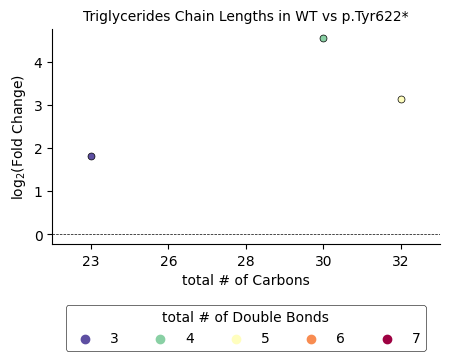

In [21]:
temp = stats[stats['class']=='TG'].copy()
plt.figure(figsize=(5, 2.8))
#
sp = sns.stripplot(data=temp, x='carbons', y='log2_fold_change', jitter=0.1, alpha = 1, hue = 'unsaturations', color = 'black', palette = 'Spectral_r', edgecolor='black', linewidth=0.5)

sp.spines['top'].set_visible(False)
sp.spines['right'].set_visible(False)

legend = plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=6, frameon=True, title='total # of Double Bonds')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.5)
plt.ylabel('log$_{2}$(Fold Change)', fontsize=10)
plt.xlabel('total # of Carbons', fontsize=10)
plt.title('Triglycerides Chain Lengths in WT vs p.Tyr622*', fontsize=10)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

#plt.xlim(-1,9)
plt.savefig('../../../paper/main_plots/tg_carbons_y622.png', dpi=300, bbox_inches='tight')


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


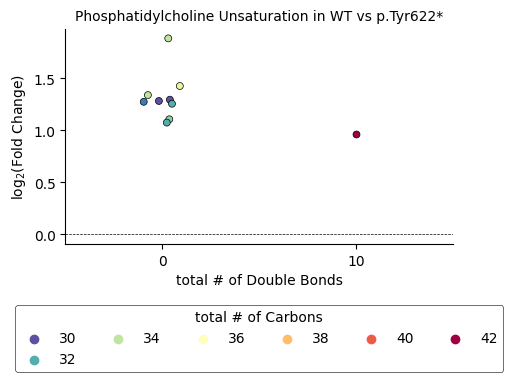

In [22]:
temp = stats[stats['class']=='PC'].copy()
plt.figure(figsize=(5, 2.8))
#
sp = sns.stripplot(data=temp, x='unsaturations', y='log2_fold_change', jitter=0.1, alpha = 1, hue = 'carbons', color = 'black', palette = 'Spectral_r', edgecolor='black', linewidth=0.5)

sp.spines['top'].set_visible(False)
sp.spines['right'].set_visible(False)

legend = plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=6, frameon=True, title='total # of Carbons')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.5)
plt.ylabel('log$_{2}$(Fold Change)', fontsize=10)
plt.xlabel('total # of Double Bonds', fontsize=10)
plt.title('Phosphatidylcholine Unsaturation in WT vs p.Tyr622*', fontsize=10)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

#plt.xlim(-1,9)
plt.savefig('../../../paper/main_plots/pc_unsat_y622.png', dpi=300, bbox_inches='tight')


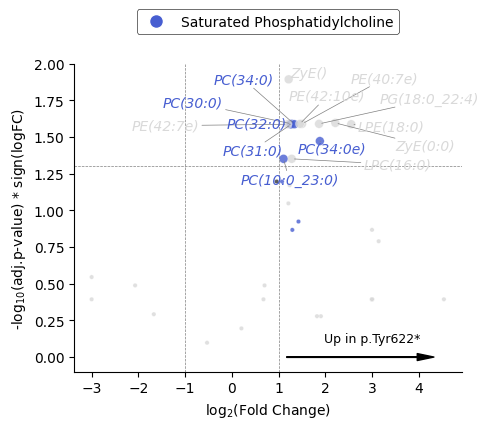

In [5]:
subset = stats.copy()
subset.loc[subset['class'] != 'PC', 'unsat_grp'] = 'other'
subset.loc[subset['log2_fold_change']==-np.inf, 'log2_fold_change'] = -3
subset.loc[subset['log2_fold_change']==np.inf, 'log2_fold_change'] = 3

palette_temp = {
    'PUFA':'#333333',
    'MUFA':'#1F2E7A',
    'SFA':'#475ED1',
    'other': '#D9D9D9'
}

plot_volcano('fdr_corrected_p_value', 'name', 'unsat_grp', 'log2_fold_change',subset, palette_temp, force_text=15, max_size=40, alpha=.8, subset_top_genes_by_lfc=True)

#plt.xlim(-2,3)
plt.ylim(-0.1,2)

plt.axvline(x=-1, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(y=1.3, color='grey', linestyle='--', linewidth=0.5)

plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')

plt.annotate('', xy=(4.5,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(3, .1, 'Up in p.Tyr622*', ha='center', fontsize=9)

# plt.annotate('', xy=(-4.5,0), xytext=(-1, 0),
#              arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
# plt.text(-2.8, .1, 'Down in p.Glu50fs*3', ha='center', fontsize=10)

labels = [
    'SFA']

handles = [
    Line2D([0], [0], marker='o', color='w', label='Saturated Phosphatidylcholine',
           markerfacecolor=palette_temp[label], markersize=10)
    for label in labels
]

legend = plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(.5, 1.2), ncol=3, frameon=True, fontsize=10)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(.5)

plt.savefig('../../../paper/main_plots/Y622_PC_volcano_sat.png', dpi=300, bbox_inches='tight')



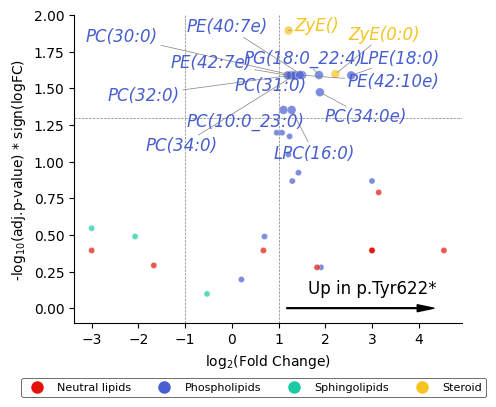

In [21]:
stats_for_volcano = stats.copy()
stats_for_volcano.loc[stats_for_volcano['log2_fold_change']==-np.inf, 'log2_fold_change'] = -3
stats_for_volcano.loc[stats_for_volcano['log2_fold_change']==np.inf, 'log2_fold_change'] = 3

plot_volcano('fdr_corrected_p_value', 'name', 'grp', 'log2_fold_change',stats_for_volcano, lipid_palette, label_size=12, force_text=10, min_size=20, max_size=40, alpha=0.7, subset_top_genes_by_lfc=True)

plt.ylim(-0.1,2)
#plt.xlim(-4,2.5)
plt.axvline(x=-1, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(y=1.3, color='grey', linestyle='--', linewidth=0.5)

plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')

plt.annotate('', xy=(4.5,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(3, .1, 'Up in p.Tyr622*', ha='center', fontsize=12)

# plt.annotate('', xy=(-2,0), xytext=(-1, 0),
#              arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
# plt.text(-2.3, .1, 'Down in p.Tyr622*\n+ CDP-choline', ha='center', fontsize=10)


labels = np.unique(stats_for_volcano['grp'])[[x!='Neutral glycerolipid' for x in np.unique(stats_for_volcano['grp'])]]
handles = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=lipid_palette[label], markersize=10)
    for label in labels
]

legend = plt.legend(handles=handles, loc='center left', bbox_to_anchor=(-0.15, -0.21), ncol=4, frameon=True, fontsize=8)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(.5)


plt.savefig('../../../paper/main_plots/all_lipids_y622.png', dpi=300, bbox_inches='tight')



In [25]:
import scipy.stats as STAT
#sf(k, M, n, N, loc=0)

def get_hypergeom_p_value(total_species, total_perturbed, total_subclass_size, subclass_perturbed):
    M = total_species              # Population size
    n = total_perturbed            # Total number of successes in the population
    N = total_subclass_size        # Number of draws
    x = subclass_perturbed         # Observed successes in the sample
    p_value = STAT.hypergeom.sf(x-1, M, n, N)
    return p_value

sfa_mufa_up_pval = get_hypergeom_p_value(stats.shape[0], stats['cat'].value_counts()['up'], 
                      stats[(stats['unsat_grp']!='PUFA')&(stats['class']=='PC')].shape[0], 
                      stats[(stats['unsat_grp']!='PUFA')&(stats['class']=='PC') & (stats['cat']=='up')].shape[0])

sfa_mufa_up_pval

0.043551356209900104

In [23]:
stats

,t_stat,p_value,log2_fold_change,fdr_corrected_p_value,cat,name,grp,class,carbons,unsaturations,unsat_grp
DG(18:0_16:0)+NH4_46.33,1.077612,0.307600,0.676965,0.403740,other,DG(18:0_16:0)+NH4_46.33,Neutral lipids,DG,34,0,SFA
DG(18:0e)+Na_34.38,-1.026205,0.331585,-inf,0.403740,other,DG(18:0e)+Na_34.38,Neutral lipids,DG,18,0,SFA
DG(23:5e)+H_37.99,1.000000,0.350617,inf,0.403740,other,DG(23:5e)+H_37.99,Neutral lipids,DG,23,5,PUFA
LPC(16:0)+H_29.72,2.849317,0.015551,1.281005,0.044501,up,LPC(16:0)+H_29.72,Phospholipids,LPC,16,0,SFA
LPC(16:2e)+H_28.54,1.321485,0.213571,0.700318,0.324628,other,LPC(16:2e)+H_28.54,Phospholipids,LPC,16,2,PUFA
LPC(18:0)+H_32.31,2.413421,0.030134,1.235859,0.067359,other,LPC(18:0)+H_32.31,Phospholipids,LPC,18,0,SFA
LPC(28:0)+H_40.17,2.212486,0.042416,1.209873,0.089545,other,LPC(28:0)+H_40.17,Phospholipids,LPC,28,0,SFA
LPE(18:0)+H_26.01,3.516428,0.005940,2.555441,0.025849,up,LPE(18:0)+H_26.01,Phospholipids,LPE,18,0,SFA
MG(18:0)+NH4_34.33,-0.770293,0.456726,-1.669340,0.510458,other,MG(18:0)+NH4_34.33,Neutral lipids,MG,18,0,SFA
PC(10:0_23:0)+H_42.82,2.763895,0.016395,1.106202,0.044501,up,PC(10:0_23:0)+H_42.82,Phospholipids,PC,33,0,SFA


## Plotting some additional metrics below

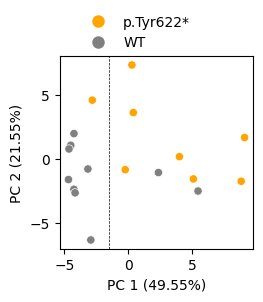

In [113]:
plot_pca(data_to_keep, names_no_blank, palette={'Y+H2O':'orange','E3+H2O' : 'grey'}, draw_median=True)

# Add a custom legend based on marker type
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
        markerfacecolor='orange', markersize=10,linestyle='None', label='p.Tyr622*'),
    Line2D([0], [0], marker='o', markerfacecolor='grey',color='w',
        markersize=10, linestyle='None', label='WT')
]
plt.legend(handles=legend_elements, title='', bbox_to_anchor=(.4, 1.28), loc='upper center', frameon=False)


## Plotting some additional metrics below

/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_ylabel(df['class'][0], rotation=0, ha='right', va='center')
/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_ylabel(df['class'][0], rotation=0, ha='right', va='center')
/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, 

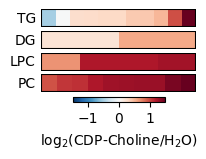

In [114]:
stats['class'] = [x.split('(')[0] for x in stats.index]
heatmap_data_list = [
    stats[stats['class'] == 'TG'],
    stats[stats['class'] == 'DG'],
    stats[stats['class'] == 'LPC'],
    stats[stats['class'] == 'PC']
]
cbar = plot_lfcs(heatmap_data_list, 'log2_fold_change')
cbar.set_label('log$_{2}$(CDP-Choline/H$_{2}$O)')

In [115]:
stats['carbons'] = stats['name'].apply(count_carbons)
stats['unsaturations'] = stats['name'].apply(count_unsaturations)


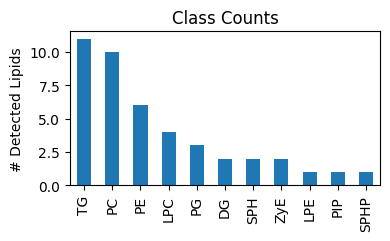

In [116]:
plt.figure(figsize=(4,2))
plot_class_counts(stats)

In [117]:
stats['unsaturations'][stats['class'] == 'TG'].nunique()

5

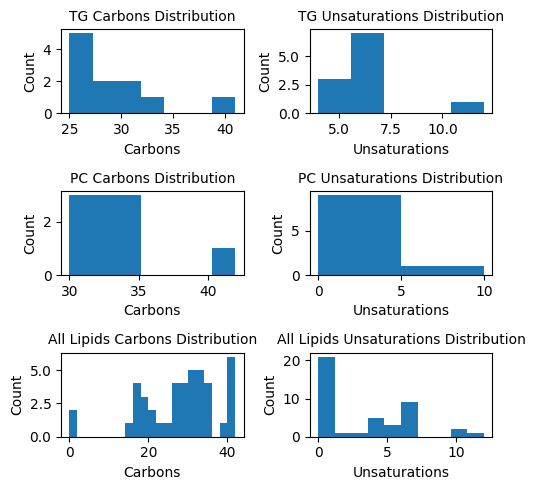

In [118]:
plot_carbon_distributions(stats)

In [33]:
# by group stats
groups = [x.split('(')[0] for x in areas_no_blank_H20_blank_removed_zeroed.index]
by_grp = areas_no_blank_H20_blank_removed_zeroed.groupby(groups).sum()
by_grp_stats = return_stats(by_grp, names_no_blank,  'E3+H2O', 'Y+H2O')

by_grp_stats['score'] = -1*np.log10(by_grp_stats['p_value']) * np.sign(by_grp_stats['log2_fold_change'])
by_grp_stats.sort_values(by='p_value')

,t_stat,p_value,log2_fold_change,fdr_corrected_p_value,score
ZyE,4.506289,0.000360,1.421897,NaN,3.443742
PG,4.730409,0.000373,2.103472,NaN,3.428076
PE,3.369632,0.005269,1.244886,NaN,2.278260
LPE,3.516428,0.005940,2.555441,NaN,2.226188
PC,3.201837,0.007356,1.237512,NaN,2.133366
LPC,2.431745,0.029421,1.142712,NaN,1.531337
TG,1.460314,0.187433,3.564332,NaN,0.727155
SPHP,-1.321575,0.210629,-2.069935,NaN,-0.676481
SPH,-1.163837,0.272268,-2.681680,NaN,-0.565004
DG,0.958058,0.369514,3.046002,NaN,0.432369


In [120]:
# classify fatty acids in TGs
selected_rows_TG = data_to_keep[np.array(groups)=='TG']

carbon_counts_classified = np.array([classify_fatty_acid_length(count_carbons(x)/3) for x in selected_rows_TG.index])

by_grp = selected_rows_TG.groupby(carbon_counts_classified).sum()
by_grp_stats = return_stats(by_grp, names_no_blank,  'E3+H2O', 'Y+H2O')
by_grp_stats



,t_stat,p_value,log2_fold_change,fdr_corrected_p_value
LCFA,1.590478,0.138328,0.267486,0.157923
MCFA,1.487676,0.157923,0.306752,0.157923


In [121]:
np.unique(carbon_counts_classified, return_counts=True)

(array(['LCFA', 'MCFA'], dtype='<U4'), array([ 1, 10]))

In [122]:
# classify fatty acids in PCs
selected_rows_PC = data_to_keep[np.array(groups)=='PC']

carbon_counts_classified = np.array([classify_unsaturation(count_unsaturations(x)) for x in selected_rows_PC.index])

by_grp = selected_rows_PC.groupby(carbon_counts_classified).sum()
by_grp_stats = return_stats(by_grp, names_no_blank,  'E3+H2O', 'Y+H2O')
by_grp_stats



,t_stat,p_value,log2_fold_change,fdr_corrected_p_value
PUFA,2.508089,0.026124,0.953098,0.026124
UFA,3.257922,0.006662,1.227203,0.013323
